# AIF End-to-End Run Notebook

This notebook is meant for a new user to **run** the Automated Interpretation Framework (AIF) on one (or more) XRD patterns.

It supports two modes:
- **Display-only**: load precomputed interpretations from `interpretations.json` (no refinement, no LLM calls).
- **Full run**: run refinement + LLM evaluation + balance/prior/posterior + plots.

> Run this notebook from the **project root** (so `src/` and `data/` resolve correctly).


## 0. Setup paths

In [1]:
import sys, os, json, time, logging
from pathlib import Path
import pandas as pd

# Resolve project root
ROOT = Path.cwd()
if (ROOT / "src").exists():
    pass
elif (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
else:
    raise RuntimeError("Couldn't find project root. Run from repo root or notebooks/.")

SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

print("ROOT:", ROOT)
print("SRC:", SRC)


ROOT: /Users/odartsi/Documents/GitHub/AIF_copy
SRC: /Users/odartsi/Documents/GitHub/AIF_copy/src


## 1. Configure what you want to run

- Set `RUN_MODE = "display"` to load precomputed interpretations.
- Set `RUN_MODE = "full"` to run refinement + LLM + scoring.


In [2]:
RUN_MODE = "full"   # "display" or "full"
SAMPLE_KEY = "TRI_197"   # e.g. "TRI_197" (or "TRI-197" depending on your files)

# Dataset registry (edit/add as needed)
DATASETS = {
    "TRI": {
        "csv": ROOT / "data" / "xrd_data" / "synthesis_data.csv",
        "combos": ROOT / "data" / "xrd_data" / "difractogram_paths.json",
        "interpretations": ROOT / "data" / "xrd_data" / "interpretations" / "interpretations.json",
    }
}

GROUP = "TRI"  # which dataset group to use

assert GROUP in DATASETS, f"GROUP must be one of {list(DATASETS)}"
cfg = DATASETS[GROUP]
cfg


{'csv': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/synthesis_data.csv'),
 'combos': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/difractogram_paths.json'),
 'interpretations': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/interpretations/interpretations.json')}

## 2. (Full run only) Configure LLM access

Your code currently expects these environment variables:

- `API_KEY` (required for LLM calls)
- *(recommended)* `API_BASE` (defaults to CBORG if your code supports it)
- *(recommended)* `MODEL` (defaults to your chosen deployment)

### If you are using CBORG
Typical values:
- `API_BASE = "https://api.cborg.lbl.gov"`
- `MODEL = "openai/gpt-4o"`

### If you are using OpenAI directly
Typical values:
- `API_BASE = "https://api.openai.com/v1"`
- `MODEL = "gpt-4o"` (or whatever you have access to)

This cell lets the user set these *inside the notebook* (no terminal export needed).


In [3]:
import os

if RUN_MODE == "full":
    if not os.getenv("API_KEY"):
        os.environ["API_KEY"] = input("Enter API_KEY: ").strip()

    os.environ.setdefault("API_BASE", "https://api.cborg.lbl.gov")
    os.environ.setdefault("MODEL", "openai/gpt-4o")

    print("API_KEY set:", "YES" if os.getenv("API_KEY") else "NO")
    print("API_BASE:", os.getenv("API_BASE"))
    print("MODEL:", os.getenv("MODEL"))
else:
    print("RUN_MODE is 'display' -> skipping LLM configuration.")


API_KEY set: YES
API_BASE: https://api.cborg.lbl.gov
MODEL: openai/gpt-4o


## 3. Load synthesis table + pattern registry

In [4]:
from utils import load_json, load_csv

df = load_csv(str(cfg["csv"]))
combos = load_json(str(cfg["combos"]))

print("Rows in synthesis CSV:", len(df))
print("Patterns in combos JSON:", len(combos))


2026-01-31 19:26:11,510	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Rows in synthesis CSV: 2
Patterns in combos JSON: 2


## 4. Select a pattern (by SAMPLE_KEY)

In [5]:
import os

def _normalize_key(k: str) -> str:
    return k.replace("-", "_")

sample_norm = _normalize_key(SAMPLE_KEY)

# Find a matching pattern_path entry
matches = [c for c in combos if _normalize_key(os.path.splitext(os.path.basename(c.get("pattern_path","")))[0]).startswith(sample_norm)]
if not matches:
    # fallback: contains
    matches = [c for c in combos if sample_norm in _normalize_key(c.get("pattern_path",""))]

if not matches:
    raise RuntimeError(f"No pattern found for SAMPLE_KEY={SAMPLE_KEY}. Try another key or inspect combos JSON.")

combo = matches[0]
pattern_path = combo["pattern_path"]
chemical_system = combo["chemical_system"]

# Pull synthesis row
filtered_df = df[df["Name"].astype(str).str.match(rf"^{sample_norm}$", na=False)]
if filtered_df.empty:
    filtered_df = df[df["Name"].astype(str).str.match(rf"^{sample_norm.replace('_','-')}$", na=False)]

if filtered_df.empty:
    raise RuntimeError(f"No synthesis row found for Name={SAMPLE_KEY} (normalized={sample_norm}) in CSV.")

target = filtered_df["Target"].iloc[0]

print("pattern_path:", pattern_path)
print("chemical_system:", chemical_system)
print("target:", target)
print("precursors:", filtered_df['Precursors'].iloc[0])


pattern_path: ../data/xrd_data/diffractogram/TRI-197.xrdml
chemical_system: Ca-V-C-O
target: CaVO2
precursors: ['CaCO3', 'V2O5']


## 5. Run AIF

- In **display** mode: loads `interpretations.json` and plots.
- In **full** mode: runs refinement + LLM + scoring and then plots.

Plots are shown inline (no file output).


In [6]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
from IPython.display import display

@contextmanager
def no_files_keep_figs():
    """Disable savefig and prevent close() so we can display figures in-notebook."""
    original_savefig = plt.savefig
    original_close = plt.close
    plt.savefig = lambda *args, **kwargs: None
    plt.close = lambda *args, **kwargs: None
    try:
        yield
    finally:
        plt.savefig = original_savefig
        plt.close = original_close


In [ ]:
# from utils import (
#     plot_metrics_contribution,
#     plot_phase_and_interpretation_probabilities,
#     normalize_scores_for_sample,
#     normalize_rwp_for_sample,
#     calculate_prior_probability,
#     calculate_fit_quality,
#     compute_trust_score,
#     flag_interpretation_trustworthiness,
#     calculate_posterior_probability_of_interpretation,
# )

# # Configure logging once
# logging.basicConfig(
#     level=logging.INFO,
#     format="%(asctime)s %(levelname)s: %(message)s",
#     handlers=[logging.StreamHandler()],
# )

# t0 = time.time()

# if RUN_MODE == "display":
#     interp_path = cfg["interpretations"]
#     if not Path(interp_path).exists():
#         raise RuntimeError(f"interpretations file not found: {interp_path}")
#     all_interpretations = json.loads(Path(interp_path).read_text())
#     key = sample_norm
#     if key not in all_interpretations and key.replace('_','-') in all_interpretations:
#         key = key.replace('_','-')
#     if key not in all_interpretations:
#         raise RuntimeError(f"{SAMPLE_KEY} not found in interpretations file ({interp_path}). Switch RUN_MODE='full' to generate it.")

#     interpretations = all_interpretations[key]

# else:
#     # Full run
#     from refinement_metrics import calculate_spectrum_likelihood_given_interpretation_wrapper
#     from LLM_evaluation import evaluate_interpretations_with_llm
#     from composition_balance import calculate_chemical_factors
#     interpretations, project_number, _target = calculate_spectrum_likelihood_given_interpretation_wrapper(
#         pattern_path, chemical_system, target, alpha=1
#     )

#     # LLM + chem + normalization + posterior pipeline
#     interpretations = evaluate_interpretations_with_llm(filtered_df, interpretations, project_number)
#     interpretations = calculate_chemical_factors(filtered_df, interpretations)

#     interpretations = normalize_scores_for_sample(interpretations)
#     interpretations = normalize_rwp_for_sample(interpretations)

#     interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore=0.7)
#     interpretations = calculate_fit_quality(interpretations, w_rwp=1, w_score=0.5)

#     interpretations = compute_trust_score(interpretations)
#     interpretations = flag_interpretation_trustworthiness(interpretations)

#     interpretations = calculate_posterior_probability_of_interpretation(interpretations)

# print("Interpretations:", list(interpretations.keys()))
# print("Elapsed:", round(time.time() - t0, 2), "sec")

# --- FULL CELL: robust + quiet "full run" (no huge logs in notebook) ---

import json, time, logging, warnings, contextlib, io
from pathlib import Path

from utils import (
    plot_metrics_contribution,
    plot_phase_and_interpretation_probabilities,
    normalize_scores_for_sample,
    normalize_rwp_for_sample,
    calculate_prior_probability,
    calculate_fit_quality,
    compute_trust_score,
    flag_interpretation_trustworthiness,
    calculate_posterior_probability_of_interpretation,
)

# Quiet notebook output
warnings.filterwarnings("ignore")
logging.getLogger().handlers.clear()
logging.basicConfig(
    level=logging.WARNING,  # <- was INFO; WARNING is much quieter
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[logging.StreamHandler()],
)

t0 = time.time()

if RUN_MODE == "display":
    interp_path = cfg["interpretations"]
    if not Path(interp_path).exists():
        raise RuntimeError(f"interpretations file not found: {interp_path}")

    all_interpretations = json.loads(Path(interp_path).read_text())
    key = sample_norm
    if key not in all_interpretations and key.replace("_", "-") in all_interpretations:
        key = key.replace("_", "-")
    if key not in all_interpretations:
        raise RuntimeError(
            f"{SAMPLE_KEY} not found in interpretations file ({interp_path}). "
            "Switch RUN_MODE='full' to generate it."
        )

    interpretations = all_interpretations[key]

else:
    # Full run
    from refinement_metrics import calculate_spectrum_likelihood_given_interpretation_wrapper
    from LLM_evaluation import evaluate_interpretations_with_llm
    from composition_balance import calculate_chemical_factors

    # 1) Refinement metrics (BGMN/eflech) – capture noisy output so notebook stays clean
    try:
        result, project_number, target = calculate_spectrum_likelihood_given_interpretation_wrapper(
        combo["pattern_path"], combo["chemical_system"], target, alpha=1)

        if result:
            interpretations = calculate_chemical_factors(filtered_df, result)
            interpretations = evaluate_interpretations_with_llm(filtered_df, result, project_number)
            interpretations = calculate_chemical_factors(filtered_df,interpretations)
            interpretations = normalize_scores_for_sample(interpretations)
            interpretations = normalize_rwp_for_sample(interpretations)
            interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
            interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
            interpretations = compute_trust_score(interpretations)
            interpretations = flag_interpretation_trustworthiness(interpretations)
            interpretations = calculate_posterior_probability_of_interpretation(interpretations)

            plot_phase_and_interpretation_probabilities(interpretations, project_number, filtered_df, target)
            plot_metrics_contribution(interpretations, project_number, target)
    except RuntimeError as e:
        msg = str(e)
        # Print a short actionable summary instead of the whole BGMN dump
        if "exit code is -11" in msg:
            print(
                "❌ BGMN crashed (segfault, exit code -11) during refinement metrics.\n"
                "This is a native-code crash (not Python/LLM). Common cause is missing "
                "instrument/VERZERR file or a bad temp run directory.\n"
                "Tip: search the error text for the temp folder path containing control.sav."
            )
        else:
            print("❌ Refinement step failed:", msg.splitlines()[0])
        raise  # stop here; to auto-skip failures you must patch the wrapper loop

    #     with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    #         interpretations, project_number, _target = (
    #             calculate_spectrum_likelihood_given_interpretation_wrapper(
    #                 pattern_path, chemical_system, target, alpha=1
    #             )
    #         )
    # except RuntimeError as e:
    #     msg = str(e)
    #     # Print a short actionable summary instead of the whole BGMN dump
    #     if "exit code is -11" in msg:
    #         print(
    #             "❌ BGMN crashed (segfault, exit code -11) during refinement metrics.\n"
    #             "This is a native-code crash (not Python/LLM). Common cause is missing "
    #             "instrument/VERZERR file or a bad temp run directory.\n"
    #             "Tip: search the error text for the temp folder path containing control.sav."
    #         )
    #     else:
    #         print("❌ Refinement step failed:", msg.splitlines()[0])
    #     raise  # stop here; to auto-skip failures you must patch the wrapper loop

    # # OPTIONAL: if your wrapper marks failures per-interpretation, keep only successful ones.
    # # (If you haven't patched the wrapper, this will do nothing.)
    # if isinstance(interpretations, dict):
    #     ok_interpretations = {k: v for k, v in interpretations.items() if v.get("bgmn_ok", True)}
    #     if len(ok_interpretations) != len(interpretations):
    #         print(f"⚠️ Dropping {len(interpretations) - len(ok_interpretations)} interpretations flagged as bgmn_ok=False")
    #     interpretations = ok_interpretations

    # # 2) LLM + chem + normalization + posterior pipeline (also kept quiet)
    # # with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):

    #     interpretations = calculate_chemical_factors(filtered_df, interpretations)
    #     print(interpretations)
    #     interpretations = evaluate_interpretations_with_llm(filtered_df, interpretations, project_number)
    #     print(interpretations)
    #     interpretations = calculate_chemical_factors(filtered_df, interpretations)
    #     print(interpretations)

    #     interpretations = normalize_scores_for_sample(interpretations)
    #     interpretations = normalize_rwp_for_sample(interpretations)

    #     interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore=0.7)
    #     interpretations = calculate_fit_quality(interpretations, w_rwp=1, w_score=0.5)

    #     interpretations = compute_trust_score(interpretations)
    #     interpretations = flag_interpretation_trustworthiness(interpretations)

    #     interpretations = calculate_posterior_probability_of_interpretation(interpretations)

print("Interpretations:", list(interpretations.keys()) if isinstance(interpretations, dict) else type(interpretations))
print("Elapsed:", round(time.time() - t0, 2), "sec")



2026-01-31 20:25:05,387 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,388 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,388 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,388 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,389 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,389 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,389 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,390 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,390 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,390 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,390 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,391 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,391 INFO dara.structure_db Skipping common gas: O2
2026-01-31 20:25:05,391 INFO dara.structure_db Skipping common gas: O2
2026-0

RuntimeError: Error in BGMN eflech for /var/folders/h9/xq939v1d36x6_ggshzfwxr840000gn/T/tmp_k1em_hb/control.sav. The exit code is -11
b'BGMN and related programs Copyright (C) J. Bergmann Dresden, FR Germany 1991-2009\nBGMN is a registered trademark of J. Bergmann\nVersion 4.2.23\nCode styled version by P. Friedel Dresden, FR Germany 2012-2013\nunable to read file VERZERR=Aeris-fds-Pixcel1d-Medipix3.ger\n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 1th range with 324 measuring points\nunable to read peak parameter start values from file output-1.par\nstarting iteration.............. Q=422.80         \nusing fast startup peak scanning\nN zweiTheta=10.8725  HWB=0.0460  Q=337.61         \n- zweiTheta=10.8624              Q=337.61         \nterminating fast startup peak scanning\nclosing iteration............... Q=337.61         \n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 2th range with 428 measuring points\nunable to read peak parameter start values from file output-2.par\nstarting iteration.............. Q=713.35         \nusing fast startup peak scanning\nN zweiTheta=13.6329  HWB=0.0462  Q=502.46         \nN zweiTheta=14.3949  HWB=0.0462  Q=479.22         \n- zweiTheta=14.3918              Q=482.77         \nterminating fast startup peak scanning\nclosing iteration............... Q=482.77         \n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 3th range with 701 measuring points\nunable to read peak parameter start values from file output-3.par\nstarting iteration.............. Q=4298.28        \nusing fast startup peak scanning\nN zweiTheta=18.0181  HWB=0.0464  Q=1864.27        \nN zweiTheta=16.6966  HWB=0.0463  Q=1394.67        \nN zweiTheta=19.8071  HWB=0.0465  Q=1138.83        \n+ zweiTheta=19.7105              Q=1128.80        \nchange of model revised\nN zweiTheta=18.4359  HWB=0.0464  Q=889.11         \nN zweiTheta=19.8769  HWB=0.0465  Q=832.84         \n- zweiTheta=19.8555              Q=836.36         \nterminating fast startup peak scanning\nclosing iteration............... Q=836.35         \n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 4th range with 2150 measuring points\nunable to read peak parameter start values from file output-4.par\nstarting iteration.............. Q=116901.12      \nusing fast startup peak scanning\nN zweiTheta=30.2052  HWB=0.0475  Q=92814.64       \nN zweiTheta=29.7070  HWB=0.0474  Q=81085.51       \nN zweiTheta=33.4225  HWB=0.0479  Q=71967.54       \n+ zweiTheta=33.4304              Q=71448.30       \nN zweiTheta=30.7040  HWB=0.0475  Q=57152.58       \n+ zweiTheta=30.2107              Q=56895.47       \nN zweiTheta=34.3329  HWB=0.0480  Q=49590.66       \nN zweiTheta=29.0673  HWB=0.0474  Q=42002.34       \n+ zweiTheta=31.0198              Q=41375.76       \nN zweiTheta=31.9179  HWB=0.0477  Q=34668.21       \n+ zweiTheta=31.8873              Q=34357.81       \nN zweiTheta=27.2008  HWB=0.0472  Q=30127.56       \n+ zweiTheta=27.1944              Q=29998.86       \nchange of model revised\nN zweiTheta=28.1922  HWB=0.0473  Q=26628.54       \n+ zweiTheta=27.1943              Q=26509.80       \nchange of model revised\nN zweiTheta=28.6413  HWB=0.0473  Q=22453.82       \nN zweiTheta=39.7231  HWB=0.0487  Q=19348.13       \nN zweiTheta=30.6803  HWB=0.0475  Q=16871.12       \nN zweiTheta=25.7646  HWB=0.0470  Q=11885.71       \n+ zweiTheta=25.7697              Q=11804.29       \nN zweiTheta=36.3293  HWB=0.0482  Q=9934.03        \n+ zweiTheta=36.3695              Q=9848.41        \nN zweiTheta=34.9571  HWB=0.0481  Q=7799.50        \n+ zweiTheta=34.8431              Q=7733.56        \n+ zweiTheta=30.6836              Q=7705.97        \nchange of model revised\nN zweiTheta=31.0131  HWB=0.0476  Q=6668.33        \nN zweiTheta=21.4562  HWB=0.0467  Q=6057.17        \nN zweiTheta=42.0958  HWB=0.0491  Q=5624.42        \nN zweiTheta=40.6260  HWB=0.0489  Q=5323.26        \nN zweiTheta=23.6061  HWB=0.0468  Q=5007.38        \n+ zweiTheta=23.5506              Q=4988.43        \nchange of model revised\nN zweiTheta=24.5904  HWB=0.0469  Q=4618.30        \n+ zweiTheta=23.5315              Q=4599.40        \nchange of model revised\nN zweiTheta=22.5068  HWB=0.0467  Q=4381.02        \n+ zweiTheta=23.5118              Q=4369.29        \nchange of model revised\nN zweiTheta=33.4704  HWB=0.0479  Q=4157.37        \n+ zweiTheta=23.5116              Q=4145.51        \nchange of model revised\nN zweiTheta=40.9194  HWB=0.0489  Q=3983.41        \n+ zweiTheta=23.5115              Q=3972.89        \nchange of model revised\nN zweiTheta=41.5071  HWB=0.0490  Q=3821.54        \n+ zweiTheta=23.5111              Q=3811.77        \nchange of model revised\n+ zweiTheta=29.0607              Q=3782.48        \n+ zweiTheta=23.5104              Q=3773.49        \nchange of model revised\nN zweiTheta=39.9425  HWB=0.0488  Q=3666.09        \n+ zweiTheta=23.5103              Q=3657.29        \nchange of model revised\nN zweiTheta=35.0051  HWB=0.0481  Q=3517.69        \n+ zweiTheta=23.5106              Q=3508.50        \nchange of model revised\nN zweiTheta=27.6490  HWB=0.0472  Q=3416.86        \n+ zweiTheta=23.5125              Q=3405.42        \nchange of model revised\nN zweiTheta=42.0467  HWB=0.0491  Q=3298.19        \n+ zweiTheta=23.5125              Q=3286.94        \nchange of model revised\nN zweiTheta=23.6530  HWB=0.0468  Q=3188.33        \nN zweiTheta=38.3371  HWB=0.0485  Q=3113.23        \nN zweiTheta=38.9443  HWB=0.0486  Q=2998.76        \nN zweiTheta=36.2810  HWB=0.0482  Q=2919.10        \nN zweiTheta=37.8038  HWB=0.0484  Q=2848.10        \nN zweiTheta=37.2471  HWB=0.0484  Q=2786.69        \nN zweiTheta=28.9016  HWB=0.0473  Q=2729.41        \nN zweiTheta=26.2585  HWB=0.0471  Q=2677.97        \nN zweiTheta=35.6305  HWB=0.0481  Q=2626.06        \nN zweiTheta=36.9087  HWB=0.0483  Q=2560.52        \nN zweiTheta=31.7511  HWB=0.0477  Q=2500.06        \nN zweiTheta=31.5129  HWB=0.0476  Q=2412.57        \nN zweiTheta=40.1986  HWB=2.4405  Q=2371.57        \nD zweiTheta=39.9396              Q=2412.60        \nchange of model revised\n- zweiTheta=36.8723              Q=2388.13        \n- zweiTheta=33.3211              Q=2390.74        \n- zweiTheta=38.3090              Q=2401.21        \n+ zweiTheta=38.3020              Q=2389.86        \n- zweiTheta=29.0734              Q=2399.00        \n- zweiTheta=39.9798              Q=2408.40        \n- zweiTheta=38.3053              Q=2426.16        \n+ zweiTheta=38.2966              Q=2408.40        \n- zweiTheta=38.3052              Q=2426.16        \n+ zweiTheta=38.2966              Q=2408.40        \n- zweiTheta=36.2783              Q=2413.78        \n- zweiTheta=38.3047              Q=2431.30        \n+ zweiTheta=38.2961              Q=2413.78        \n- zweiTheta=36.4134              Q=2417.44        \n- zweiTheta=38.3044              Q=2434.85        \n+ zweiTheta=38.2956              Q=2417.44        \n- zweiTheta=38.3042              Q=2434.85        \n+ zweiTheta=38.2956              Q=2417.44        \n- zweiTheta=38.3042              Q=2434.85        \n+ zweiTheta=38.2956              Q=2417.44        \n- zweiTheta=38.3042              Q=2434.85        \n+ zweiTheta=38.2956              Q=2417.44        \n- zweiTheta=38.3042              Q=2434.85        \n+ zweiTheta=38.2956              Q=2417.44        \n- zweiTheta=35.6377              Q=2426.04        \n- zweiTheta=38.3055              Q=2443.51        \n+ zweiTheta=38.2969              Q=2426.03        \n- zweiTheta=38.3055              Q=2443.51        \n+ zweiTheta=38.2968              Q=2426.03        \n- zweiTheta=38.3055              Q=2443.51        \n+ zweiTheta=38.2968              Q=2426.03        \n- zweiTheta=25.7658              Q=2428.86        \n- zweiTheta=28.9363              Q=2435.81        \n- zweiTheta=27.6478              Q=2439.53        \n- zweiTheta=31.7321              Q=2443.77        \n- zweiTheta=38.3062              Q=2461.56        \n+ zweiTheta=38.2976              Q=2443.78        \n- zweiTheta=31.3100              Q=2443.78        \n- zweiTheta=31.3100              Q=2454.98        \n- zweiTheta=26.2534              Q=2455.77        \n- zweiTheta=23.6404              Q=2457.18        \n- zweiTheta=38.3062              Q=2474.93        \n+ zweiTheta=38.2975              Q=2457.18        \nterminating fast startup peak scanning\n- zweiTheta=38.3061              Q=2474.93        \nsenseless peak deleted.......... Q=2509.11        \nsenseless peak deleted.......... Q=2598.85        \nsenseless peak deleted.......... Q=2927.67        \nsenseless peak deleted.......... Q=3575.65        \n+ zweiTheta=25.7678              Q=3506.83        \n+ zweiTheta=36.4212              Q=3468.73        \n+ zweiTheta=40.6968              Q=3445.96        \nD zweiTheta=26.2406              Q=3459.52        \nchange of model revised\n- zweiTheta=34.6448              Q=2458.32        \n- zweiTheta=38.3061              Q=2476.07        \nsenseless peak deleted.......... Q=2510.21        \nsenseless peak deleted.......... Q=2599.99        \nsenseless peak deleted.......... Q=2964.66        \nsenseless peak deleted.......... Q=2964.62        \nsenseless peak deleted.......... Q=3609.26        \n+ zweiTheta=40.7042              Q=3586.04        \n+ zweiTheta=25.7678              Q=3516.73        \n+ zweiTheta=36.4239              Q=3485.28        \nD zweiTheta=26.2406              Q=3498.75        \nchange of model revised\n- zweiTheta=31.9275              Q=2458.32        \n- zweiTheta=38.3061              Q=2476.07        \nsenseless peak deleted.......... Q=2510.26        \nsenseless peak deleted.......... Q=2599.97        \nsenseless peak deleted.......... Q=2928.65        \nsenseless peak deleted.......... Q=3577.99        \n+ zweiTheta=25.7678              Q=3509.15        \n+ zweiTheta=36.4211              Q=3471.00        \n+ zweiTheta=40.6966              Q=3448.20        \nD zweiTheta=26.2406              Q=3461.67        \nchange of model revised\nclosing iteration............... Q=2458.31        \n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 5th range with 293 measuring points\nunable to read peak parameter start values from file output-5.par\nstarting iteration.............. Q=5764.40        \nusing fast startup peak scanning\nN zweiTheta=43.4602  HWB=0.0493  Q=2433.23        \n+ zweiTheta=43.5790              Q=2253.25        \nN zweiTheta=43.8552  HWB=0.0494  Q=617.45         \n+ zweiTheta=43.8284              Q=590.02         \nterminating fast startup peak scanning\nclosing iteration............... Q=590.02         \n1th pattern file named TRI-197.xy: assuming free XY[E] format\nEvaluation of 6th range with 2360 measuring points\nunable to read peak parameter start values from file output-6.par\nstarting iteration..............'
b''

In [23]:
interpretations

{'I_1': {'phases': ['CaC2_2_(cod_1540818)-9'],
  'phase_cifs': ['cifs/CaC2_2_(cod_1540818)-9.cif'],
  'phase_icsd': [None],
  'weight_fraction': [100.0],
  'rwp': 17.92,
  'search_result_rwp': 20.01,
  'search_result_score': -0.0004081414659724265,
  'score': -0.016218883805087028,
  'normalized_rwp': 0.7013333333333333,
  'missing_peaks': 77,
  'extra_peaks': 12,
  'peaks_calculated': 26,
  'peaks_observed': 104,
  'signal_above_bkg_score': 10486.60165739402,
  'bkg_overshoot_score': 1582.2362407919877,
  'cell_parameters': {'a': 0.39306,
   'b': 0.74035,
   'c': 0.74101,
   'alpha': 69.4202,
   'beta': 87.4977,
   'gamma': (87.45, 0.16)},
  'interpretation_importance': 0.0,
  'balance_score': 0.375,
  'normalized_score': 0.3133393920912693}}

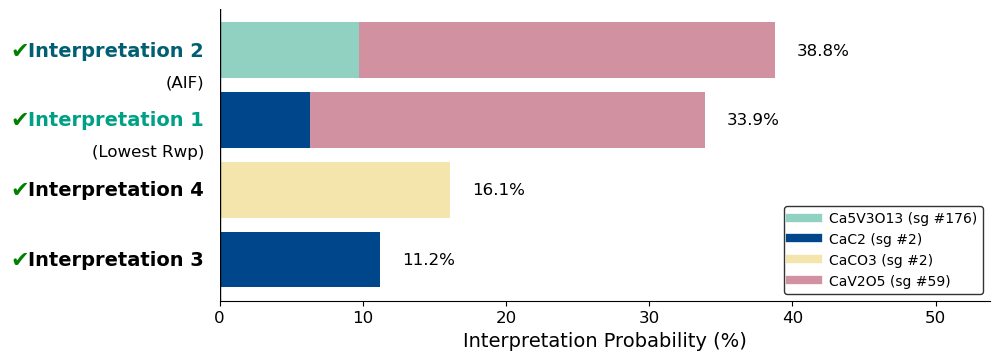

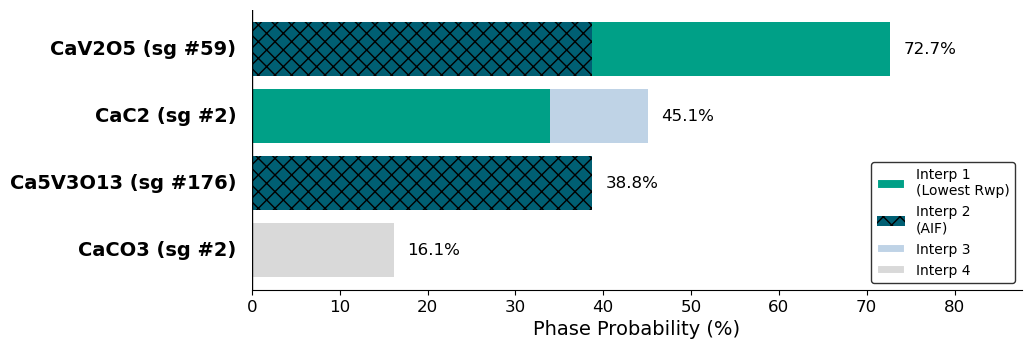

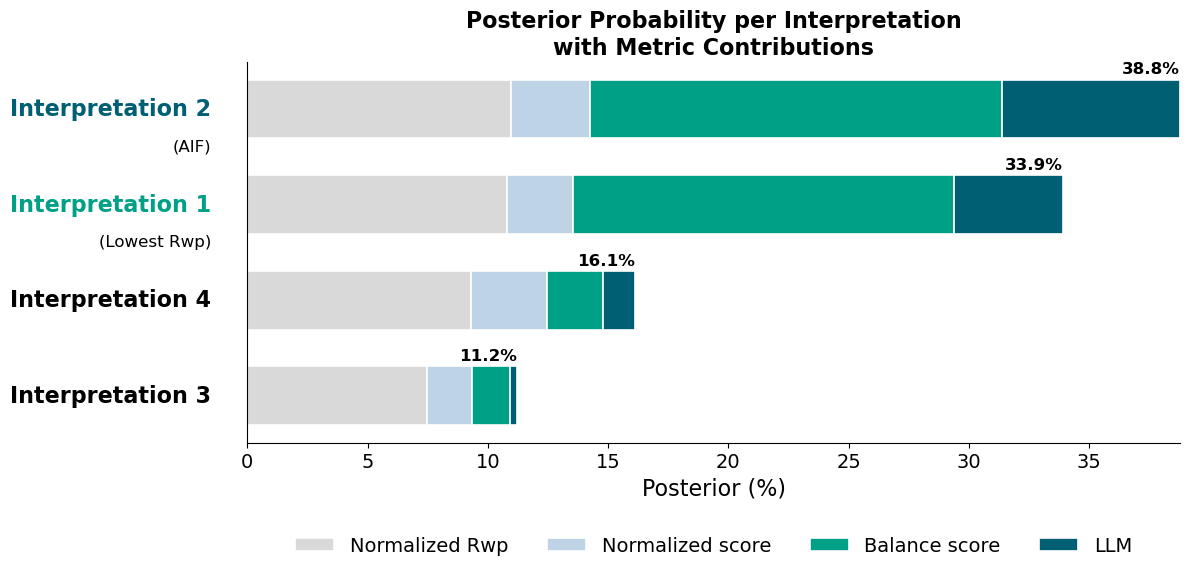

In [ ]:
# Display plots inline
with no_files_keep_figs():
    plot_phase_and_interpretation_probabilities(interpretations, sample_norm, filtered_df, target)
    plot_metrics_contribution(interpretations, sample_norm, target)

# Let Jupyter render open figures once
plt.show()


## 6. Print a compact summary table

In [16]:
import pandas as pd

rows = []
for k, v in interpretations.items():
    rows.append({
        "interp": k,
        "phases": ", ".join(v.get("phases", [])),
        "LLM": v.get("LLM_interpretation_likelihood"),
        "balance": v.get("balance_score"),
        "rwp": v.get("rwp"),
        "norm_rwp": v.get("normalized_rwp"),
        "norm_score": v.get("normalized_score"),
        "prior": v.get("prior_probability"),
        "posterior": v.get("posterior_probability"),
        "trust": v.get("trust_score"),
        "trustworthy": v.get("trustworthy"),
    })

summary = pd.DataFrame(rows).sort_values("posterior", ascending=False)
summary


,interp,phases,LLM,balance,rwp,norm_rwp,norm_score,prior,posterior,trust,trustworthy
1,I_2,"CaV2O5_59, Ca5V3O13_176",0.6,0.9919,16.27,0.728833,0.437652,0.828608,0.387693,0.985889,True
0,I_1,"CaC2_2, CaV2O5_59",0.4,0.9984,16.16,0.730667,0.371643,0.749067,0.338948,0.983046,True
3,I_4,CaCO3_2,0.3,0.3750,17.39,0.710167,0.479508,0.343750,0.161219,0.866229,True
2,I_3,CaC2_2,0.1,0.3750,18.05,0.699167,0.346018,0.260417,0.112140,0.697867,True


(raylet) [2026-01-31 14:16:44,498 E 8761 49724281] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2026-01-31_13-52-23_787608_7579 is over 95% full, available space: 24706629632; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2026-01-31 14:16:54,591 E 8761 49724281] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2026-01-31_13-52-23_787608_7579 is over 95% full, available space: 21568229376; capacity: 494384795648. Object creation will fail if spilling is required.
